In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.fft as npf
import matplotlib
import matplotlib.pyplot as plt
import time
import imagetools as im

from IPython.display import clear_output

# 4

In [2]:
x = plt.imread('assets/starfish.png')

In [3]:
y = plt.imread('assets/topgun.png')

Text(0.5, 1.0, 'Random masking')

/Users/eseetao/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


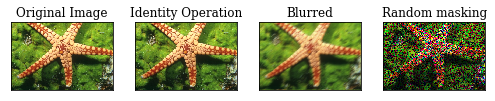

In [4]:
random_masking = im.RandomMasking(x.shape,0.4)
identity = im.Identity(x.shape)
motion_blur = im.Convolution(x.shape,im.kernel("motion"))

fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(7,15))
axes[0].imshow(x)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("Original Image")

axes[1].imshow(identity(x))
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("Identity Operation")

axes[2].imshow(motion_blur(x))
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title("Blurred")

axes[3].imshow(random_masking(x))
axes[3].set_xticks([])
axes[3].set_yticks([])
axes[3].set_title("Random masking")

# 5

In [5]:
def matrix_product(x,y):
    '''
    computes matrix dot product
    '''
    return np.sum(x*y)

## Random Masking

In [6]:
print("Comparison of matrix products <Hx,y> and <x,H*y> returns {}".format(np.allclose(matrix_product(random_masking(x),y),matrix_product(x,random_masking.adjoint(y)))))

Comparison of matrix products <Hx,y> and <x,H*y> returns True


## Identity

In [7]:
print("Comparison of matrix products <Hx,y> and <x,H*y> returns {}".format(np.allclose(matrix_product(identity(x),y),matrix_product(x,identity.adjoint(y)))))

Comparison of matrix products <Hx,y> and <x,H*y> returns True


## Convolution

In [8]:
print("Comparison of matrix products <Hx,y> and <x,H*y> returns {}".format(np.allclose(matrix_product(motion_blur(x),y),matrix_product(x,motion_blur.adjoint(y)))))

Comparison of matrix products <Hx,y> and <x,H*y> returns True


# 6

In [9]:
def inv_gram_res(obj,x,tau):
    '''
    Computes inverse of gram resolvent matrix
    Args:
        obj: operation
        x: input image
        tau: constant of regularization
    Returns:
        inverse of gram resolvent
    '''
    return x + (tau*obj.adjoint(obj(x)))

## Identity

In [10]:
confirm = identity.gram_resolvent(inv_gram_res(identity,x,2),2)
print("Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is {0}".format(np.allclose(confirm,x)))

Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is True


## Random Masking

In [11]:
confirm = random_masking.gram_resolvent(inv_gram_res(random_masking,x,2),2)
print("Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is {}".format(np.allclose(confirm,x)))

Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is True


## Motion Blur

In [12]:
confirm = motion_blur.gram_resolvent(inv_gram_res(motion_blur,x,2),2)
print("Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is {}".format(np.allclose(confirm,x,atol=1e-2)))

Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is True


# 8 

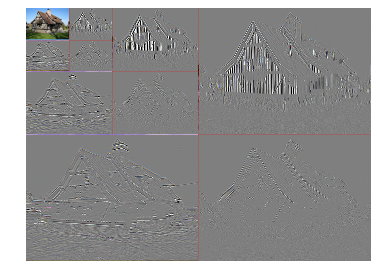

In [13]:
x0 = plt.imread("assets/normandy.png")
J = 3
h,g = im.wavelet('db2')
y0 = im.dwt(im.dwt_crop(x0,J),J,h,g)
im.showdwt(y0,J=3)

# 9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


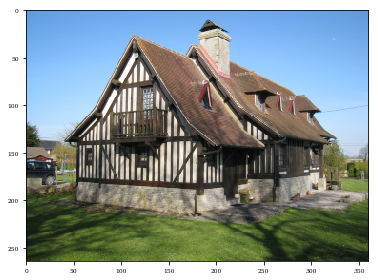

In [14]:
x = im.idwt(y0,J,h,g)
plt.imshow(x)

# 10

In [15]:
confirm = im.dwt(im.idwt(y0,J,h,g),J,h,g)
print("Confirm if dwt is left inverse idwt of {}".format(np.allclose(confirm,y0)))

Confirm if dwt is left inverse idwt of True


In [16]:
confirm = im.idwt(im.dwt(im.dwt_crop(x0,J),J,h,g),J,h,g)
print("Confirm if idwt is left inverse dwt of {}".format(np.allclose(confirm,im.dwt_crop(x0,J))))

Confirm if idwt is left inverse dwt of True


In [17]:
x=im.dwt_crop(plt.imread('assets/starfish.png'),J)
y =im.dwt_crop(plt.imread('assets/topgun.png'),J)
print("Confirm that idwt in adjoint of dwt {}".format(np.allclose(matrix_product(im.dwt(x,J,h,g),y),matrix_product(x,im.idwt(y,J,h,g)))))

Confirm that idwt in adjoint of dwt True


# 12

In [18]:
def softthresh(z,t):
    '''
    Implements soft thresholding of matrix z with threshold t
    Args:
        z: array
        t: threshold
    Returns:
        threshold: thresholded version of z
    '''
    
    threshold = np.maximum(z-t,np.zeros_like(z))+np.minimum(z+t,np.zeros_like(z))
    
    return threshold

## 13

In [19]:
def softthresh_denoise(y, sig, W, alpha=10/255):
    '''
    Removes noise by performing soft-thresholding on the wavelet coefficients
    Args:
        y: image
        sig: standard deviation
        W: wavelet transformation
    Kwargs:
        alpha: scaling factor
    Returns:
        Denoised image
    '''
    
    coeff = W(y)
    tau = np.sqrt(2)*np.square(sig)/(alpha*W.power())
    return softthresh(coeff,tau)

# 14

In [20]:
J=3
clean = im.dwt_crop(plt.imread("assets/dragonfly.png"),J)
W = im.DWT(clean.shape,J)
sig = 20 / 255
noisy = clean + sig * np.random.randn(*clean.shape)
#psnr = [im.psnr(clean,W.invert(softthresh_denoise(noisy, sig, W, alpha=i/255))) for i in [6/255, 8/255, 10/255, 12/255,16/255,20/255]]
psnr = [im.psnr(clean,W.invert(softthresh_denoise(noisy, sig, W, alpha=i/255))) for i in range(3,20)]

Text(0.5, 0, 'alpha')

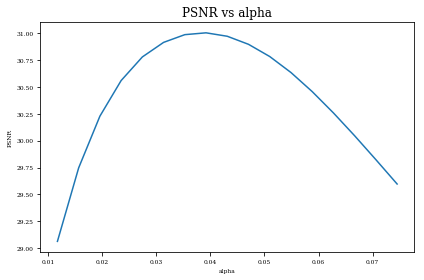

In [21]:
plt.plot([i/255 for i in range(3,20)],psnr)
plt.title("PSNR vs alpha")
plt.ylabel("PSNR")
plt.xlabel("alpha")

# 15 & 17

In [22]:
def interleave0(x):
    '''
    Upsample the filters h and g in udwt by injecting 2^(j − 1) zeros between each entries.
    Args:
        x: input vector
        j: interleaving factor
    Returns:
        x1: interleaved vector
    '''
    x1=np.zeros(((x.shape[0]-1)*2+1,1))
    x1[::2,:]=x
    return x1


def udwt(x, J, h, g):
    '''
    Implements the 2d Undecimated Discrete Wavelet Transform (UDWT) with J scales
    Args:
        x: image
        J: scales
        h: filter h
        g: filter g
    Returns:
        z: udwt transformation
    '''
    if J == 0:
        return x[:, :, None]
    tmph = np.rot90(im.convolve(np.rot90(x,k=3), h),k=1) / 2
    tmpg = np.rot90(im.convolve(np.rot90(x,k=3), g),k=1) / 2     
    z = np.stack((im.convolve(tmpg, h),im.convolve(tmph, g),im.convolve(tmph, h)), axis=2)
    coarse = im.convolve(tmpg, g)
    h2 = interleave0(h)
    g2 = interleave0(g)
    z = np.concatenate((udwt(coarse, J - 1, h2, g2), z),axis=2)
    return z

def iudwt(z, J, h, g):
    '''
    Implements the 2d Inverse UDWT
    Args:
        z: input img
        J: scales
        h: filter h
        g: filter g
    Returns:
        x: the 2D inverse UDWT
    '''
    if J == 0:
        return z[:, :, 0]
    h2 = interleave0(h)
    g2 = interleave0(g)
    coarse = iudwt(z[:, :, :-3], J - 1, h2, g2)
    tmpg = im.convolve(coarse, g[::-1]) + im.convolve(z[:, :, -3], h[::-1])
    tmph = im.convolve(z[:, :, -2], g[::-1]) + im.convolve(z[:, :, -1], h[::-1])
    x = (np.rot90(im.convolve(np.rot90(tmpg,k=3), g[::-1]),k=1) + np.rot90(im.convolve(np.rot90(tmph,k=3), h[::-1]),k=1)) / 2
    return x

In [23]:
x0 = plt.imread("assets/dragonfly.png")
source = im.dwt_crop(x0,J)
undec_wavelet = udwt(source,J,h,g)
inverse = iudwt(undec_wavelet,J,h,g)
reverse = udwt(iudwt(undec_wavelet,J,h,g),J,h,g)

## 16

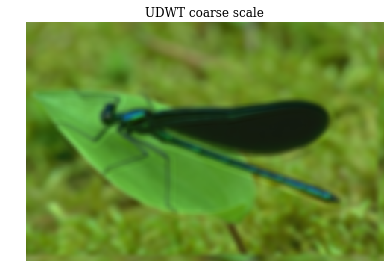

In [24]:
im.show(undec_wavelet[:,:,0,:])
plt.title("UDWT coarse scale")
plt.show()

Text(0.5, 1.0, 'Detailed Scale #6')

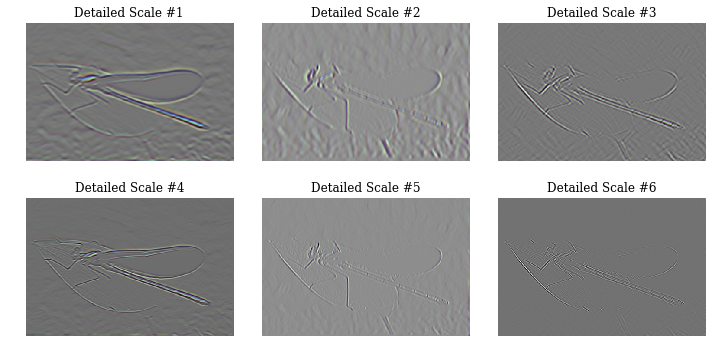

In [25]:
fig,axes= plt.subplots(nrows=2,ncols=3,figsize=(10,5))
im.show(undec_wavelet[:,:,1,:],vmin=np.min(undec_wavelet[:,:,1,:]),vmax=np.max(undec_wavelet[:,:,1,:]),ax=axes[0][0])
axes[0][0].set_title("Detailed Scale #1")
im.show(undec_wavelet[:,:,2,:],vmin=np.min(undec_wavelet[:,:,2,:]),vmax=np.max(undec_wavelet[:,:,2,:]),ax=axes[0][1])
axes[0][1].set_title("Detailed Scale #2")
im.show(undec_wavelet[:,:,3,:],vmin=np.min(undec_wavelet[:,:,3,:]),vmax=np.max(undec_wavelet[:,:,3,:]),ax=axes[0][2])
axes[0][2].set_title("Detailed Scale #3")
im.show(undec_wavelet[:,:,4,:],vmin=np.min(undec_wavelet[:,:,4,:]),vmax=np.max(undec_wavelet[:,:,4,:]),ax=axes[1][0])
axes[1][0].set_title("Detailed Scale #4")
im.show(undec_wavelet[:,:,5,:],vmin=np.min(undec_wavelet[:,:,5,:]),vmax=np.max(undec_wavelet[:,:,5,:]),ax=axes[1][1])
axes[1][1].set_title("Detailed Scale #5")
im.show(undec_wavelet[:,:,6,:],vmin=np.min(undec_wavelet[:,:,6,:]),vmax=np.max(undec_wavelet[:,:,6,:]),ax=axes[1][2])
axes[1][2].set_title("Detailed Scale #6")

## 18

In [26]:
print("Checking udwt and iudwt are left invert of each other",np.allclose(source,inverse))
print("Checking udwt and iudwt are right invert of each other",np.allclose(reverse,undec_wavelet))

Checking udwt and iudwt are left invert of each other True
Checking udwt and iudwt are right invert of each other False


UDWT and IUDWT operates in different dimensions, as such they cannot be adjoints of each other. UDWT is invertible but IUDWT is not invertible. Since the UDWT operator is not square, it is not invert

## 21

Text(0.5, 1.0, 'Soft thresholding PSNR:32.47')

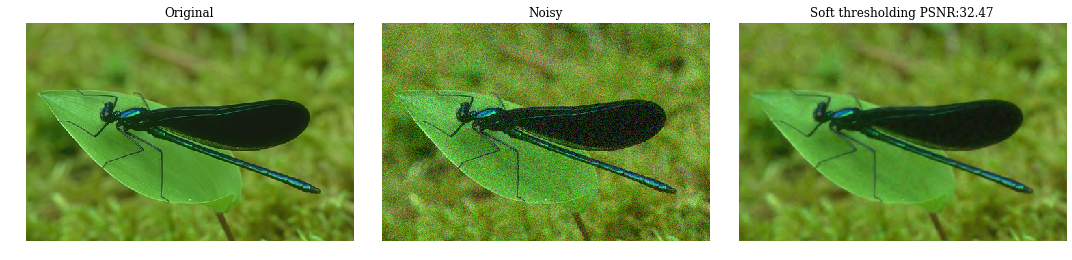

In [27]:
x0 = plt.imread("assets/dragonfly.png")
clean = im.dwt_crop(x0,J)
W = im.UDWT(clean.shape,J)
sig = 20 / 255
noisy = clean + sig * np.random.randn(*clean.shape)
start = time.time()
UDWT_soft_thresh = W.invert(softthresh_denoise(noisy,20/255,W))
end = time.time()

fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(15,7))
im.show(clean,ax=axes[0])
axes[0].set_title("Original")
im.show(noisy,ax=axes[1])
axes[1].set_title("Noisy")
im.show(UDWT_soft_thresh,ax=axes[2])
axes[2].set_title("Soft thresholding PSNR:{}".format(np.round(im.psnr(clean,UDWT_soft_thresh),decimals=2)))

In [28]:
print("Time taken for filter bank implementation {}".format(end-start))

Time taken for filter bank implementation 2.6025967597961426


Text(0.5, 1.0, 'Soft thresholding PSNR:18.66')

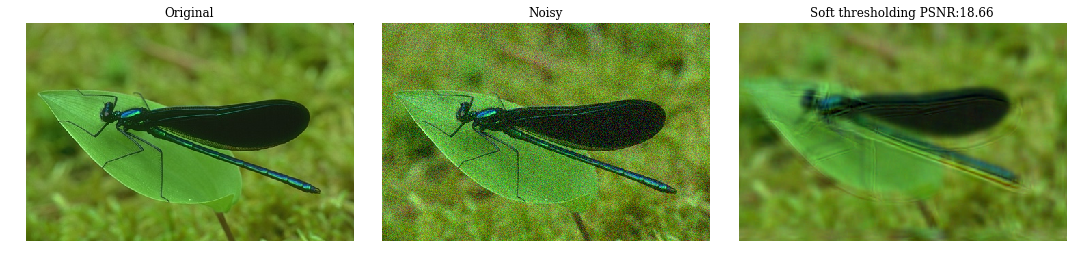

In [29]:
x0 = plt.imread("assets/dragonfly.png")
clean = im.dwt_crop(x0,J)
W = im.UDWT(clean.shape,J,using_fb=False)
sig = 20 / 255
noisy = clean + sig * np.random.randn(*clean.shape)
start = time.time()
UDWT_soft_thresh = W.invert(softthresh_denoise(noisy,20/255,W))
end = time.time()

fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(15,7))
im.show(clean,ax=axes[0])
axes[0].set_title("Original")
im.show(noisy,ax=axes[1])
axes[1].set_title("Noisy")
im.show(UDWT_soft_thresh,ax=axes[2])
axes[2].set_title("Soft thresholding PSNR:{}".format(np.round(im.psnr(clean,UDWT_soft_thresh),decimals=2)))

In [30]:
print("Time taken for naive implementation {}".format(end-start))

Time taken for naive implementation 7.383333921432495


Text(0.5, 1.0, 'Soft thresholding PSNR:31.02')

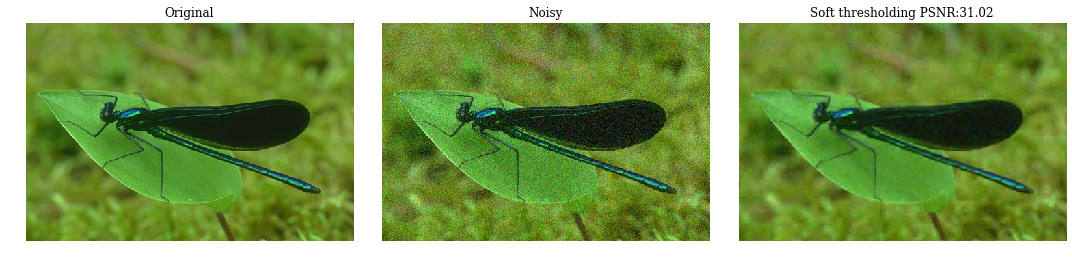

In [31]:
x0 = plt.imread("assets/dragonfly.png")
clean = im.dwt_crop(x0,J)
W = im.DWT(clean.shape,J)
sig = 20 / 255
noisy = clean + sig * np.random.randn(*clean.shape)
DWT_soft_thresh = W.invert(softthresh_denoise(noisy,20/255,W))

fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(15,7))
im.show(clean,ax=axes[0])
axes[0].set_title("Original")
im.show(noisy,ax=axes[1])
axes[1].set_title("Noisy")
im.show(DWT_soft_thresh,ax=axes[2])
axes[2].set_title("Soft thresholding PSNR:{}".format(np.round(im.psnr(clean,DWT_soft_thresh),decimals=2)))

## 22

In [85]:
def sparse_analysis_regularization(y, sig, W, H=None, m=40, alpha=10/255, gamma=1, return_energy=False):
    '''
    Computes the sparse analysis regularization via wavelet coefficients
    Args:
        y: noisy image
        sig: standard deviation
        W: (undecimated)/discrete wavelet transformation
        H: kernel linear operator
        m: iterations
        alpha: scaling factor
        gamma: must be > 0
    Kwargs:
        return_energy: if False, returns only x, if True, returns both x and e
    Returns:
        x: approximate image
        e: energy
    '''
    
    n = len(y)
    #n = len(W(x))
    if H is None:
        H = im.Identity(y.shape)

    lamb = alpha*W.power()
    A=1
        
    #initialization
    x_til = H.adjoint(y)
    z_til = W(x_til)
    dx = 0
    dz = 0
    e = []

    #tau = np.sqrt(2*np.sqrt(n/len(z_til)))*np.square(sig)
    tau = np.sqrt(2*np.sqrt(0.25))*np.square(sig)
    
    for i in range(m):
        
        x = H.gram_resolvent(x_til+dx+gamma*H.adjoint(y),gamma)
        z = softthresh(z_til+dz,gamma*tau/lamb)
        
        x_til = W.gram_resolvent(x-dx+W.adjoint(z-dz),1)
        z_til = W(x_til)
        
        dx = dx - x + x_til
        dz = dz - z + z_til
        
        energy1 = 0.5*np.square(np.linalg.norm(y-H(x)))
        #energy2 = tau*np.linalg.norm(W(x),ord=1)
        #energy2 = tau*np.linalg.norm(np.linalg.inv(A)*W(x),ord=1)
        e.append(energy1)
        #energy = energy1 + energy2
        print("energy is", energy1)        
        print("finished", i+1, "iterations")
    
    if return_energy:
        return x, e
    else:
        return x

## 23

In [33]:
# clean = im.dwt_crop(plt.imread("assets/dragonfly.png"),J)
# W = im.DWT(clean.shape,J)
# sig = 20 / 255
# ydragonfly = clean + sig * np.random.randn(*clean.shape)

# DWT_SAR_dragonfly,e = sparse_analysis_regularization(ydragonfly, sig, W, return_energy=True)

In [34]:
clean = im.dwt_crop(plt.imread("assets/dragonfly.png"),J)
W = im.UDWT(clean.shape,J)
sig = 20 / 255
ydragonfly = clean + sig * np.random.randn(*clean.shape)

UDWT_SAR_dragonfly = sparse_analysis_regularization(ydragonfly, sig, W)

energy is 0.0
finished 1 iterations
energy is 326.50111068955016
finished 2 iterations
energy is 757.5249596302491
finished 3 iterations
energy is 1052.2025947975335
finished 4 iterations
energy is 1225.1110035096797
finished 5 iterations
energy is 1321.552223508987
finished 6 iterations
energy is 1374.8005187541435
finished 7 iterations
energy is 1404.603149589371
finished 8 iterations
energy is 1421.8322071285531
finished 9 iterations
energy is 1432.2986394959898
finished 10 iterations
energy is 1439.0592023154322
finished 11 iterations
energy is 1443.722319472606
finished 12 iterations
energy is 1447.1576093048634
finished 13 iterations
energy is 1449.8328814973274
finished 14 iterations
energy is 1452.0153097510436
finished 15 iterations
energy is 1453.855673712706
finished 16 iterations
energy is 1455.4431242723265
finished 17 iterations
energy is 1456.8350289034065
finished 18 iterations
energy is 1458.0725312295922
finished 19 iterations
energy is 1459.1842431735145
finished 20 

In [35]:
x0 = plt.imread("assets/dragonfly.png")
clean = im.dwt_crop(x0,J)
sig = 20/255
noisy = clean + sig*np.random.randn(*clean.shape)

W = im.DWT(clean.shape,J)
DWT_soft_thresh = W.invert(softthresh_denoise(noisy,sig,W))

W = im.UDWT(clean.shape,J)
UDWT_soft_thresh = W.invert(softthresh_denoise(noisy,sig,W))

Text(0.5, 1.0, 'SAR with UDWT (31.85db)')

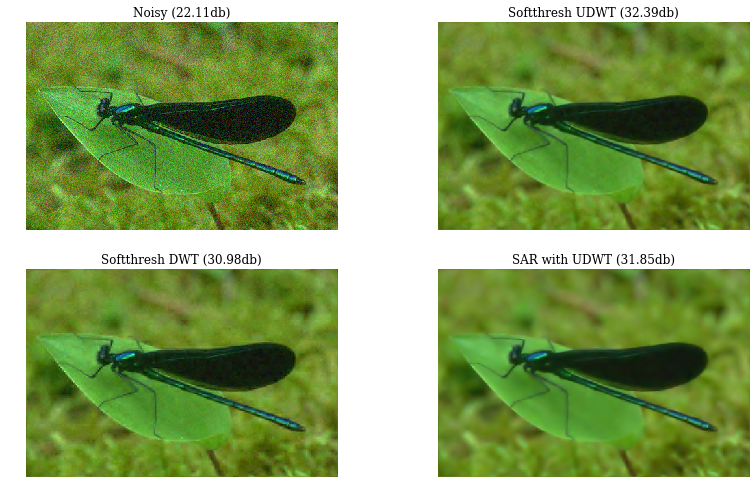

In [48]:
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(15,7))
im.show(ydragonfly,ax=axes[0][0])
axes[0][0].set_title("Noisy ({}db)".format(np.round(im.psnr(clean,ydragonfly),decimals=2)))
im.show(DWT_soft_thresh,ax=axes[1][0])
axes[1][0].set_title("Softthresh DWT ({}db)".format(np.round(im.psnr(clean,DWT_soft_thresh),decimals=2)))
im.show(UDWT_soft_thresh,ax=axes[0][1])
axes[0][1].set_title("Softthresh UDWT ({}db)".format(np.round(im.psnr(clean,UDWT_soft_thresh),decimals=2)))
im.show(UDWT_SAR_dragonfly,ax=axes[1][1])
axes[1][1].set_title("SAR with UDWT ({}db)".format(np.round(im.psnr(clean,UDWT_SAR_dragonfly),decimals=2)))

## 24

In [86]:
clean = im.dwt_crop(plt.imread("assets/topgun.png"),J)
W = im.DWT(clean.shape,J)
sig = 2 / 255
y = clean + sig * np.random.randn(*clean.shape)
motion_blur = im.Convolution(y.shape,im.kernel("motion"))
yblurry = motion_blur(y)

H = im.Convolution(y.shape,im.kernel("motion"))
DWT_SAR,e_DWT = sparse_analysis_regularization(yblurry, sig, W, H=H, m=20, gamma=100, return_energy=True)

energy is 4.6880227383010755
finished 1 iterations
energy is 4.793069500804674
finished 2 iterations
energy is 4.679111984166441
finished 3 iterations
energy is 4.498704389823754
finished 4 iterations
energy is 4.457682295191067
finished 5 iterations
energy is 3.8722465848433743
finished 6 iterations
energy is 3.9089292844485306
finished 7 iterations
energy is 3.9238215129000378
finished 8 iterations
energy is 3.949029773804662
finished 9 iterations
energy is 3.9866142064952146
finished 10 iterations
energy is 4.0308083732218805
finished 11 iterations
energy is 4.076355075149332
finished 12 iterations
energy is 4.119350031958241
finished 13 iterations
energy is 4.157564126109085
finished 14 iterations
energy is 4.190187743833057
finished 15 iterations
energy is 4.217401406126352
finished 16 iterations
energy is 4.239848545551295
finished 17 iterations
energy is 4.258328526404559
finished 18 iterations
energy is 4.273644331739385
finished 19 iterations
energy is 4.286492784163785
finish

In [87]:
clean = im.dwt_crop(plt.imread("assets/topgun.png"),J)
W = im.UDWT(clean.shape,J)
sig = 2 / 255
y = clean + sig * np.random.randn(*clean.shape)
motion_blur = im.Convolution(y.shape,im.kernel("motion"))
yblurry = motion_blur(y)

H = im.Convolution(y.shape,im.kernel("motion"))
UDWT_SAR,e_UDWT = sparse_analysis_regularization(yblurry, sig, W, H=H, m=20, gamma=100, return_energy=True)

energy is 4.6875459963430375
finished 1 iterations
energy is 4.7856828581270054
finished 2 iterations
energy is 4.587918964598578
finished 3 iterations
energy is 4.3404077037184265
finished 4 iterations
energy is 4.21787939246626
finished 5 iterations
energy is 4.1728692563335645
finished 6 iterations
energy is 4.178056742907548
finished 7 iterations
energy is 4.222592080633775
finished 8 iterations
energy is 4.284736146142467
finished 9 iterations
energy is 4.344144205089778
finished 10 iterations
energy is 4.3924521175665365
finished 11 iterations
energy is 4.429909984434547
finished 12 iterations
energy is 4.459346915633443
finished 13 iterations
energy is 4.483426889542106
finished 14 iterations
energy is 4.50398325085781
finished 15 iterations
energy is 4.5220089153733145
finished 16 iterations
energy is 4.537952482498673
finished 17 iterations
energy is 4.5520493490287155
finished 18 iterations
energy is 4.564526629173021
finished 19 iterations
energy is 4.575549933601703
finishe

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'SAR with UDWT (27.09db)')

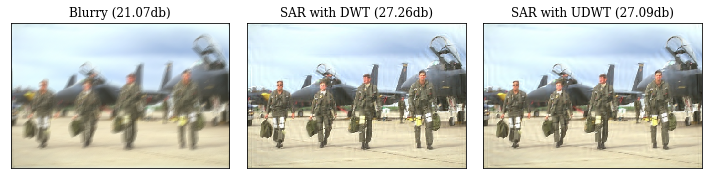

In [88]:
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,25))
axes[0].imshow(motion_blur(y))
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("Blurry ({}db)".format(np.round(im.psnr(clean,yblurry),decimals=2)))

axes[1].imshow(DWT_SAR)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("SAR with DWT ({}db)".format(np.round(im.psnr(clean,DWT_SAR),decimals=2)))

axes[2].imshow(UDWT_SAR)
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title("SAR with UDWT ({}db)".format(np.round(im.psnr(clean,UDWT_SAR),decimals=2)))

## 25

In [93]:
#random masking 40%

clean = im.dwt_crop(plt.imread("assets/topgun.png"),J)
sig = 2 / 255
y = clean + sig * np.random.randn(*clean.shape)
random_masking = im.RandomMasking(y.shape,0.4)

H = im.RandomMasking(y.shape,0.4)

In [94]:
W = im.DWT(clean.shape,J)
DWT_SAR_masking = sparse_analysis_regularization(random_masking(y), sig, W, H=H, gamma=100)

energy is 33098.5228261364
finished 1 iterations
energy is 33098.775904138376
finished 2 iterations
energy is 33099.09225164078
finished 3 iterations
energy is 33099.134576851764
finished 4 iterations
energy is 33099.00411536218
finished 5 iterations
energy is 33098.88094505543
finished 6 iterations
energy is 33098.821867093204
finished 7 iterations
energy is 33098.813093913166
finished 8 iterations
energy is 33098.83000701611
finished 9 iterations
energy is 33098.851199004974
finished 10 iterations
energy is 33098.86365369795
finished 11 iterations
energy is 33098.86525372125
finished 12 iterations
energy is 33098.86053868991
finished 13 iterations
energy is 33098.85480839925
finished 14 iterations
energy is 33098.850933063695
finished 15 iterations
energy is 33098.8492966802
finished 16 iterations
energy is 33098.849010046
finished 17 iterations
energy is 33098.84903475202
finished 18 iterations
energy is 33098.84876061702
finished 19 iterations
energy is 33098.84806303723
finished 2

In [95]:
W = im.UDWT(clean.shape,J)
UDWT_SAR_masking = sparse_analysis_regularization(random_masking(y), sig, W, H=H, gamma=100)

energy is 33098.5228261364
finished 1 iterations
energy is 33098.73809538101
finished 2 iterations
energy is 33099.016315280605
finished 3 iterations
energy is 33099.042027172734
finished 4 iterations
energy is 33098.91501346165
finished 5 iterations
energy is 33098.800857214264
finished 6 iterations
energy is 33098.750285856404
finished 7 iterations
energy is 33098.748813914346
finished 8 iterations
energy is 33098.771701442245
finished 9 iterations
energy is 33098.79701641457
finished 10 iterations
energy is 33098.81144281412
finished 11 iterations
energy is 33098.81337118151
finished 12 iterations
energy is 33098.80849906549
finished 13 iterations
energy is 33098.80301540261
finished 14 iterations
energy is 33098.800036956956
finished 15 iterations
energy is 33098.79972800428
finished 16 iterations
energy is 33098.80081040275
finished 17 iterations
energy is 33098.80191846218
finished 18 iterations
energy is 33098.80234538805
finished 19 iterations
energy is 33098.80206933414
finish

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'SAR with UDWT (7.08db)')

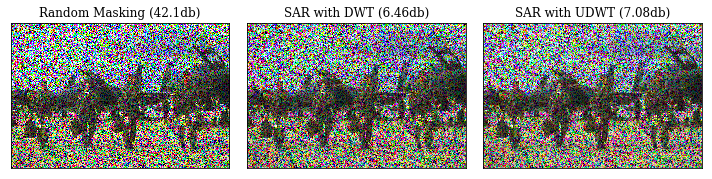

In [96]:
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,25))
axes[0].imshow(random_masking(y))
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("Random Masking ({}db)".format(np.round(im.psnr(clean,y),decimals=2)))

axes[1].imshow(DWT_SAR_masking)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("SAR with DWT ({}db)".format(np.round(im.psnr(clean,DWT_SAR_masking),decimals=2)))

axes[2].imshow(UDWT_SAR_masking)
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title("SAR with UDWT ({}db)".format(np.round(im.psnr(clean,UDWT_SAR_masking),decimals=2)))